Same stuff as in part one to set up the environment and grab the data.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)

Function to create the shifted images, I am guessing there is a smarter way to do this that requires less lines of code, but I was having trouble finding anything. But it runs through each image and then uses a shift function for each direction and then appends it to the list, I initially struggled because I forgot about having to transfer it back and forth between list and numpy array.

In [ ]:
from scipy.ndimage.interpolation import shift

def ShiftExpand(X_array, y_array):
    X_expanded = [image for image in X_array]
    y_expanded = [label for label in y_array]

    for image, label in zip(X_array, y_array):
        X_expanded.append(shift(image.reshape(28, 28), [1,0], cval=0).reshape(784))
        y_expanded.append(label)
        X_expanded.append(shift(image.reshape(28, 28), [-1,0], cval=0).reshape(784))
        y_expanded.append(label)
        X_expanded.append(shift(image.reshape(28, 28), [0,1], cval=0).reshape(784))
        y_expanded.append(label)
        X_expanded.append(shift(image.reshape(28, 28), [0,-1], cval=0).reshape(784))
        y_expanded.append(label)

    X_expanded, y_expanded = np.array(X_expanded), np.array(y_expanded)

    return X_expanded, y_expanded

Testing the shift and expand function to see what the results look like

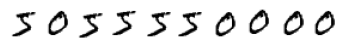

In [ ]:
X_temp, y_temp = np.array([X[0],X[1]]), np.array([y[0],y[1]])
#X_temp.shape
X_temp, y_temp = ShiftExpand(X_temp, y_temp)


plot_digits(X_temp, images_per_row=10)
plt.show()

splitting the train and test data, and then using the shift and expand function on the train data

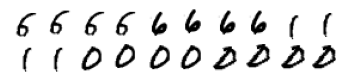

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42)

X_train, y_train = ShiftExpand(X_train, y_train)

plot_digits(X_train[-20:], images_per_row=10)
plt.show()

Creating the model with the train data using the optimum hyperparameters that I determined in part one

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
FinalModel = KNeighborsClassifier(n_neighbors=4, weights='distance')
FinalModel.fit(X_train, y_train)

y_prediction = FinalModel.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_prediction)

0.991

(I don't know what is happening anymore, the last five times I ran this I got around 63%, but now when commenting it the accuracy is equal with the result when randomizing the order whcih makes sense to me, but I haven't made any changeds to the code and it didn't work before so I don't know what was going on.)

For some reason this is terrible, worse than before augmenting the data, still not sure why. I ended up checking the example from the author and the only difference I could find was the randomization of order so I emplemented that

In [ ]:
def ShiftExpandNShuffle(X_array, y_array):
    X_expanded = [image for image in X_array]
    y_expanded = [label for label in y_array]

    for image, label in zip(X_array, y_array):
        X_expanded.append(shift(image.reshape(28, 28), [1,0], cval=0).reshape(784))
        y_expanded.append(label)
        X_expanded.append(shift(image.reshape(28, 28), [-1,0], cval=0).reshape(784))
        y_expanded.append(label)
        X_expanded.append(shift(image.reshape(28, 28), [0,1], cval=0).reshape(784))
        y_expanded.append(label)
        X_expanded.append(shift(image.reshape(28, 28), [0,-1], cval=0).reshape(784))
        y_expanded.append(label)

    X_expanded, y_expanded = np.array(X_expanded), np.array(y_expanded)

    randInd = np.random.permutation(len(X_expanded))
    X_expanded = X_expanded[randInd]
    y_expanded = y_expanded[randInd]

    return X_expanded, y_expanded

Now I test the new shift function to see if the randomization was working

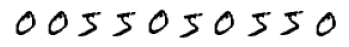

In [ ]:
X_temp, y_temp = np.array([X[0],X[1]]), np.array([y[0],y[1]])
#X_temp.shape
X_temp, y_temp = ShiftExpandNShuffle(X_temp, y_temp)


plot_digits(X_temp, images_per_row=10)
plt.show()

Splitting the train/test sets, and using the shift function to augment the train dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42)

X_train, y_train = ShiftExpandNShuffle(X_train, y_train)

X_train.shape, y_train.shape

((345000, 784), (345000,))

Creating the model based on the optimum hyperparameters that we discovered in part one and trainging it on the augmented dataset.

In [ ]:
FinalModel = KNeighborsClassifier(n_neighbors=4, weights='distance')
FinalModel.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

Testing the model on the test data.

In [ ]:
y_prediction = FinalModel.predict(X_test)

accuracy_score(y_test, y_prediction)

0.991

There is a whole 0.8% improvement using the data augmentation method.